# Passive Stock Fund Optimization - Ticker-level Prediction Product

In [2]:
# Quality of life
import os
import time
import warnings
from collections import defaultdict

# I/O and data structures
import pickle
import pandas as pd
import numpy as np

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

# Model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn import metrics

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Magic
%matplotlib inline
%load_ext pycodestyle_magic
sns.set_style('darkgrid')

In [4]:
warnings.filterwarnings('ignore')

## Set-up

#### Imports

In [5]:
# Import modeling helper functions
from modeling_funcs import *

In [6]:
# Import
inpath = "model_dictionary.pickle"
with open(inpath, 'rb') as f:
    modeling = pickle.load(f)

In [7]:
# Pull out the features dataframe
train = modeling['features']

In [8]:
# Remove tickers with fewer than 5-years worth of data
ticker_counts = train['ticker'].value_counts().reset_index().rename({'ticker':'count','index':'ticker'}, axis=1)
keep_tickers = ticker_counts.loc[ticker_counts['count'] >= (252*5), 'ticker'].tolist()
keep_idx = train['ticker'].isin(keep_tickers)
train = train[keep_idx]

#### Feature selection

In [9]:
# Set a feature selection list
features = ['High', 'Low', 'Close', 'Volume', 'AdjClose', 'Week', 'Dayofyear', 
            'Pct_Change_Monthly', 'Pct_Change_Yearly', 'RSI', 'Volatility',
            'Yearly_Return_Rank', 'Monthly_Return_Rank',
            'Rolling_Yearly_Mean_Positive_Days', 'Rolling_Monthly_Mean_Positive_Days', 
            'Rolling_Monthly_Mean_Price', 'Rolling_Yearly_Mean_Price',
            'Momentum_Quality_Monthly', 'Momentum_Quality_Yearly', 'SPY_Trailing_Month_Return',
            'open_l10',  'return_prev5_close_raw', 'return_prev10_close_raw',
            'pe_ratio', 'debt_ratio', 'roa',
            'beta']

In [10]:
# Select on features to pass to modeling machinery, along with necessary indexers
X = train[features]
tickers = train['ticker'].unique().tolist()

In [11]:
# Choose a ticker - remove the tickers as above
target = modeling['target_21_rel_return']
target = target[keep_idx]

# Modeling

## Ticker-level

In [39]:
t = 'AAPL'

In [42]:
# Pull only feature/target data for the relevant ticker
X_t = X.loc[train['ticker'] == t,:]
y_t = np.array(target)[train['ticker'] == t]
    
# Indexes of hold-out test data (the 21 days of data preceding the present day)
test_idx = np.where(np.isnan(y_t))[0].tolist()

# Simple feature-scaling - for now, replace missings with 0 (i.e. the mean of a normalized feature)
X_t = X_t.apply(lambda x: (x - np.mean(x))/np.std(x)).fillna(0)

# Remove hold-out test data
y_t = np.delete(y_t, test_idx)
X_t_holdout = X_t.loc[X_t.index[test_idx]]
X_t = X_t.drop(X_t.index[test_idx])
    
# Fit and evaluate
model_dict = fit_lgbm_classifier(X_t, 
                                 y_t,
                                 X_t_holdout, 
                                 ticker=t, 
                                 ema_gamma=1, 
                                 n_splits=12,
                                 cv_method='ts', 
                                 labeled=False,
                                 param_search=None,
                                 holdout_method='distributed',
                                 threshold_search=True,
                                 export=False)


0 targets changed by smoothing.
Training model on validation split #1
Training model on validation split #2
Training model on validation split #3
Training model on validation split #4
Training model on validation split #5
Training model on validation split #6
Training model on validation split #7
Training model on validation split #8
Training model on validation split #9
Training model on validation split #10
Training model on validation split #11
Training model on validation split #12
Build, hyperparameter selection, and validation of LGBM Classifier took 5.085 seconds

Average AUC across 12 splits: 0.5763516759328878
('beta', 77.75000000000001)
('Rolling_Yearly_Mean_Price', 77.08333333333333)
('Dayofyear', 73.66666666666666)
('Volatility', 55.41666666666667)
('Momentum_Quality_Yearly', 50.5)
('Rolling_Monthly_Mean_Price', 49.25000000000001)


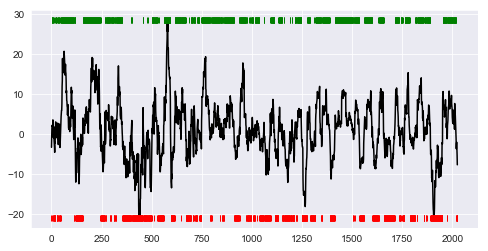

In [41]:
fig, ax = plt.subplots(figsize=(8,4))

ticker_dates = train.loc[train['ticker'] == t,'date_of_transaction']

x = pd.Series(y_t)
#print(x)#x.index = pd.to_datetime(ticker_dates[:len(x)])
#print(x)
bounds = [max(x), min(x)]
top_rug = bounds[0]*model_dict['preds_df']['expected']
bottom_rug = -min(x)*(model_dict['preds_df']['expected']-1)
top_rug = np.where(top_rug == 0, np.nan, top_rug)
bottom_rug = np.where(bottom_rug == 0, np.nan, bottom_rug)
ax.plot(x.index, x, color='k')

ax.plot(bottom_rug, '|', color='r')
ax.plot(top_rug, '|', color='g')
plt.show()

In [37]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

trace_high = go.Scatter(
    x=pd.to_datetime(ticker_dates[:len(x)]),
    y=x,
    name = t,
    line = dict(color = '#17BECF'),
    opacity = 0.8)

data = [trace_high]

layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Time Series with Rangeslider")

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jarbis_/0 or inside your plot.ly account where it is named 'Time Series with Rangeslider'


In [36]:
import plotly
plotly.tools.set_credentials_file(username='jarbis_', api_key='ioNPenrXvgS79jPwqUsM')

In [ ]:
pd.to_